# Notebook to finetune Finnish Version of BERT (https://github.com/TurkuNLP/FinBERT)



In [1]:
#Data
import pandas as pd
train_df = pd.read_csv("data/train.csv")
labels = train_df.ministry.unique()
classnames = {}
for i, label in enumerate(labels):
    classnames[label] = i
    
def labelfromclass(classname):
    return classnames[classname]

def classfromlabel(label):
    keys = list(classnames.keys())
    values = list(classnames.values())
    return keys[values.index(label)]

print(labels)

['sisäministeri' 'oikeus- ja työministeri'
 'maatalous- ja ympäristöministeri' 'perhe- ja peruspalveluministeri'
 'sosiaali- ja terveysministeri' 'opetus- ja kulttuuriministeri'
 'eurooppa-, kulttuuri- ja urheiluministeri'
 'liikenne- ja viestintäministeri' 'ulkoministeri' 'pääministeri'
 'valtiovarainministeri' 'elinkeinoministeri'
 'kunta- ja uudistusministeri' 'puolustusministeri'
 'ulkomaankauppa- ja kehitysministeri']


In [2]:
train_df.head(10)

,sentence,ministry
0,Hallituksen esityksen 43/2016vp valmistelussa ...,sisäministeri
1,Suojaosuuden nostaminen vähentäisi kaikkien ve...,oikeus- ja työministeri
2,Edistämällä puun käyttöä rakentamisessa tuetaa...,maatalous- ja ympäristöministeri
3,Valvira ja aluehallintovirastot ovat ottaneet ...,perhe- ja peruspalveluministeri
4,Lainmuutoksessa säädettiin vaativan lääkinnäll...,sosiaali- ja terveysministeri
5,"Hilan tehtävänä on siis päättää , mitkä lääkke...",sosiaali- ja terveysministeri
6,Ammattikorkeakoulujen opiskelijakunnista sääde...,opetus- ja kulttuuriministeri
7,"Kysymyksessäkin todetusti on tärkeää , että ty...",sosiaali- ja terveysministeri
8,Laki ei sinällään sisällä sanktioita työntekij...,perhe- ja peruspalveluministeri
9,Sibeliuksen syntymäpäivän 8.12. ja Eurooppa-pä...,sisäministeri


In [3]:
print(labelfromclass('sisäministeri'))
print(classfromlabel(0))

0
sisäministeri


<AxesSubplot:>

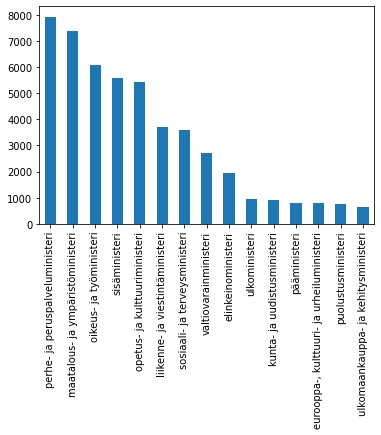

In [4]:
#Count of different classes
#Very uneven distribution of classes
import seaborn as sns
train_df.ministry.value_counts().plot(kind='bar')

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch
import transformers


tokenizer = transformers.BertTokenizer.from_pretrained("TurkuNLP/bert-base-finnish-uncased-v1")


class TextClassificationDataset(Dataset):
    """
    Dataset class for textclassification
    """
    def __init__(self, datafile):
        
        try:
            self.dataframe = pd.read_csv(datafile)
        except:
            print(f"opening file:{datafile} failed")
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        sentence = row['sentence']
        label = labelfromclass(row['ministry'])
        return sentence, label
            

def collate_func(batch):
    """
    collate function handles tokenization and attention mask
    """
    sents, labels = zip(*batch)
    encoding = tokenizer(list(sents), return_tensors='pt', padding=True, truncation=True ,max_length=256)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    return (input_ids, attention_mask, torch.tensor(labels).unsqueeze(0)) 

   
trainset = TextClassificationDataset("data/train.csv")
evalset = TextClassificationDataset("data/dev.csv")
dataloader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate_func)

In [6]:
#Test dataloader
for batch in dataloader:
    print(batch)
    break

(tensor([[  102,  1006,  7301,  ...,     0,     0,     0],
        [  102, 27931,   171,  ...,     0,     0,     0],
        [  102,  2841,  2110,  ...,     0,     0,     0],
        ...,
        [  102, 16347, 29412,  ...,     0,     0,     0],
        [  102,  1364,  2331,  ...,     0,     0,     0],
        [  102,  7203,   120,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([[10, 12,  5,  5,  5,  2,  0,  5,  4,  3,  0,  9,  5,  2,  0,  5,  3,  4,
          1,  3,  2,  2,  2, 11,  2,  3,  2,  5, 12,  3,  5,  4]]))


In [43]:
#Define Model


Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50101, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from transformers import AdamW, BertForSequenceClassification
from tqdm.notebook import tqdm

#Parameters
epochs = 2
BATCH_SIZE = 32
LR=2e-5
device = 'cuda'

print("initializing model")
model = BertForSequenceClassification.from_pretrained("TurkuNLP/bert-base-finnish-uncased-v1", num_labels=len(labels))
model.train()
model.to(device)

print("initializing datasets and optimizer")
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=collate_func)
evalloader = DataLoader(evalset, batch_size=BATCH_SIZE, collate_fn=collate_func)
optimizer = AdamW(model.parameters(), lr=1e-5)

print("starting training")

for epoch in range(epochs):
    print(f"starting epoch:{epoch+1}")
    i=0
    losses = []
    for data in tqdm(trainloader):
        i+=1
        
        optimizer.zero_grad()
        
        inputs, attention_mask, labels = data
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(sum(losses)/len(losses))
#for data in evalloader

initializing model


Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

initializing datasets and optimizer
starting training
starting epoch:1


  0%|          | 0/1535 [00:00<?, ?it/s]

1.1569744387356389
starting epoch:2


  0%|          | 0/1535 [00:00<?, ?it/s]

# Things to add:
## learning rate scheduler
## gradient clipping
## techniques to balance class inbalances
## hyperparameter optimization